## About
MNIST Digit classification using Deep Neural Network in PyTorch.

In [3]:
import torch
from torch import Tensor
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader


In [4]:
# downloading MNIST dataset with transforms 
transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
#downloading train and test data
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST('data',train=False, download=True,transform=transforms)


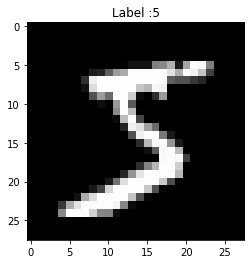

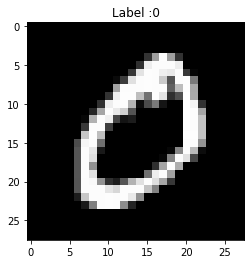

In [5]:
#Visualising data samples from train and test dataset
for i in range(2):
    image,label = train_data[i]
    plt.imshow(image[0],cmap='gray')
    plt.title("Label :{}".format(label))
    plt.show()

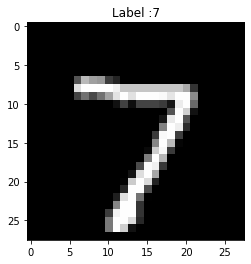

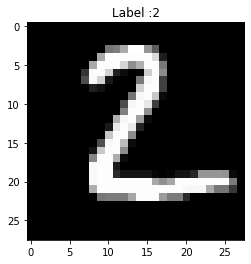

In [6]:
for i in range(2):
    image,label = test_data[i]
    plt.imshow(image[0],cmap='gray')
    plt.title("Label :{}".format(label))
    plt.show()

In [7]:
# splitting the train dataset into train, val split
val_len = 15000
train_len = len(train_data)-val_len
train_set, val_set = random_split(train_data,[train_len,val_len])
print("Length of training samples is {}".format(len(train_set)))
print("Length of testing samples is {}".format(len(val_set)))

Length of training samples is 45000
Length of testing samples is 15000


In [8]:
#creating dataloaders i.e train and val
batch_size =256
train_loader = DataLoader(train_set,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size,shuffle=True,  num_workers=4, pin_memory=True)

In [9]:
input_size=784 # 28*28
num_classes = 10

In [10]:
# function for calculating accuracy
def accuracy(outputs, labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [11]:
# defining the evaluate function
def evaluate(model,validation_dataloader):
    outputs = [model.validation_step(batch) for batch in validation_dataloader]
    return model.validation_epoch_end(outputs)

# Architecture of the Deep Neural Network.

1. Input layer - batchsize,784
2. Linear layer - 784,256
3. Non-Linear Activation - ReLU
4. Linear Layer - 256, 128
5. ReLU
6. Linear Layer - 128,64
7. ReLU
8. Linear Layer- 64, 10(N-classes)
9. Softmax Activation

In [32]:
#let's create the model class by extending nn.module
class DeepNeuralNetwork(nn.Module):
    def __init__(self,in_size,hidden_size,out_size) -> None:
        super().__init__() #constructor of nn.Module
        #hidden layers
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,128)
        self.linear3 = nn.Linear(128,64)
        # output layer 
        self.linear4 = nn.Linear(64,out_size)
    
    #defining the forward pass
    def forward(self,inputs) -> Tensor:
        #flatten the image tensor
        inputs = inputs.view(inputs.size(0),-1)
        #passing the input through hidden layers
        out = self.linear1(inputs)
        #applying ReLU
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        #passing through output layer
        out = self.linear4(out)
        return out

    #defining training step
    def training_step(self,batch) -> dict:
        images,labels = batch
        logits = self(images) # self here is the model
        loss = F.cross_entropy(logits,labels)
        train_acc = accuracy(logits,labels)
        return loss
    
    #defining validation step
    def validation_step(self,batch) -> dict:
        images,labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits,labels)
        acc = accuracy(logits,labels)
        return {'val_loss': loss, 'val_acc':acc}

    def validation_epoch_end(self,outputs) -> dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accuray = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuray).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}


    def epoch_end(self,epoch,result) -> None:
        print("Epoch [{}], val_loss :{:4f}, val_acc: {:4f}".format(epoch+1,result['val_loss'], result['val_acc']))


# Training phase - Boiler plate code
```for epoch in range(num_epochs):
    #training
    for batch in train_dataloader:
    # step1 - generate logits ie predictions from the model
    # step 2 - calculate loss
    # step3 - compute gradients
    # step4 - update weights via optimizer.step
    # step 4 = reset gradients - optimizers.zero_grad
    # step 5 - calculate metrics

    # validation
    for batch in val_dataloader
        #step 1 - generate logits
        # step 2 - calculate loss
        # step 3 - calculate metrics
    
    #calculate average loss of train and val and thus display
    ```

In [33]:
def fit(num_epochs, learning_rate, model,train_data_loader,val_dataloader, optimizer=torch.optim.Adam):
    optimizer = optimizer(model.parameters(), learning_rate)
    history = []

    for epoch in range(num_epochs):
        #training phase
        batch_loss = []
        for batch in train_data_loader:
            loss = model.training_step(batch)
            batch_loss.append(loss)
            loss.backward()
            optimizer.step()
            #resetting grads to zero
            optimizer.zero_grad()
        print("Training loss over the batch is {}".format(sum(batch_loss)/len(batch_loss)))

        #validation phase
        result = evaluate(model,val_dataloader)
        model.epoch_end(epoch,result)
        history.append(result)
    
    return history



#### Sending model and data loader to GPU


In [34]:
torch.cuda.is_available()

False

In [35]:
def compute_device():
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

In [36]:
device = compute_device()
device

device(type='cpu')

In [37]:
#moving data and model to a deice
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [38]:
# example usage
for images, labels in train_loader:
    images = to_device(images,device)
    break

In [39]:
#Defining the class of Device Data loader
class DeviceDataLoader():
    def __init__(self,data_loader,device) -> None:
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self):
        for batch in self.data_loader:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data_loader)


In [40]:
#moving the dataloaders to the device
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

In [42]:
#training model
model = DeepNeuralNetwork(input_size,256,10)
history = fit(50,0.01,model,train_data_loader=train_loader,val_dataloader=val_loader)

Training loss over the batch is 0.32771745324134827
Epoch [1], val_loss :0.156941, val_acc: 0.950027
Training loss over the batch is 0.1258416324853897
Epoch [2], val_loss :0.132122, val_acc: 0.963973
Training loss over the batch is 0.0922369509935379
Epoch [3], val_loss :0.120640, val_acc: 0.965366
Training loss over the batch is 0.07752814888954163
Epoch [4], val_loss :0.127446, val_acc: 0.964464
Training loss over the batch is 0.06745831668376923
Epoch [5], val_loss :0.114397, val_acc: 0.968722
Training loss over the batch is 0.06023750081658363
Epoch [6], val_loss :0.133274, val_acc: 0.966074
Training loss over the batch is 0.054345861077308655
Epoch [7], val_loss :0.115321, val_acc: 0.969653
Training loss over the batch is 0.044236600399017334
Epoch [8], val_loss :0.115845, val_acc: 0.973911
Training loss over the batch is 0.047228362411260605
Epoch [9], val_loss :0.134664, val_acc: 0.970353
Training loss over the batch is 0.041752930730581284
Epoch [10], val_loss :0.138443, val_a

Text(0.5, 1.0, 'Accuracy plot')

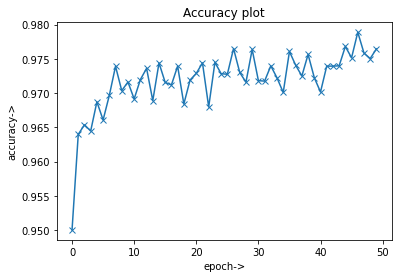

In [43]:
# plotting the curves
accuracy = [result['val_acc'] for result in history]
plt.plot(accuracy,'-x')
plt.xlabel('epoch->')
plt.ylabel('accuracy->')
plt.title('Accuracy plot')

Text(0.5, 1.0, 'Loss plot')

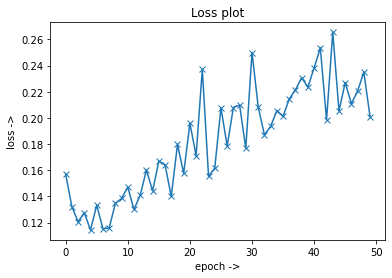

In [47]:
# plotting the curves
loss = [result['val_loss'] for result in history]
plt.plot(loss,'-x')
plt.xlabel('epoch ->')
plt.ylabel('loss ->')
plt.title('Loss plot')

In [45]:
# predicting on test_image
def predict(image,model):
    #img_data = image.reshape(-1,784)
    img_data = image.unsqueeze(0)
    #print(img_data.shape)
    probs = model(img_data)
    _, preds = torch.max(probs,dim=1)
    #print(preds[0].item)
    return preds[0].item()
    #return "Predicted Label is".format(dataset_labels_dict[str(preds[0].item())])


In [46]:
img,label = test_data[0]
print(predict(img,model))

7


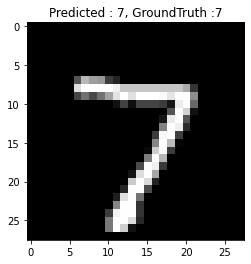

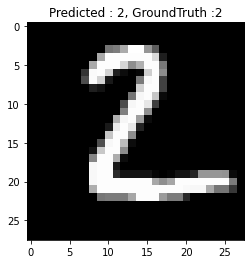

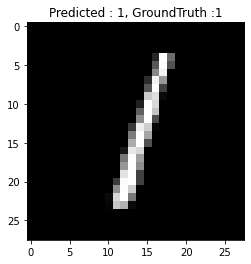

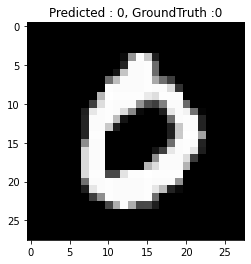

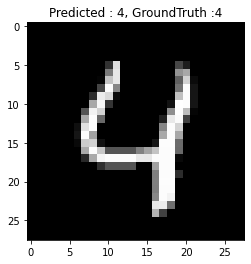

In [49]:

for i in range(5):
    img,label = test_data[i]
    plt.imshow(img[0],cmap='gray')
    plt.title("Predicted : {}, GroundTruth :{}".format(predict(img,model),label))
    plt.show()


In [50]:
# saving the model by saving state_dict
torch.save(model.state_dict(), 'mnist-dnn.pth')

In [52]:
# to view the weights and bias after training, refer the state_dict
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-2.9612e-04, -2.8280e-02,  7.0305e-03,  ...,  3.2761e-02,
                       -2.4835e-02,  3.3478e-02],
                      [ 2.9376e-02,  1.7778e-03, -2.5865e-02,  ..., -9.5249e-03,
                        2.1956e-02,  6.7684e-03],
                      [-3.1234e-02,  2.4562e-02, -2.5044e-02,  ..., -1.9789e-02,
                       -2.6436e-02, -3.1422e-02],
                      ...,
                      [ 2.4822e-02,  1.9090e-02,  1.9609e-02,  ...,  4.5589e-03,
                       -3.7856e-03,  7.8716e-03],
                      [ 9.4375e-03, -7.7796e-03,  2.0688e-02,  ..., -1.9826e-02,
                       -2.8653e-02, -4.7323e-03],
                      [-2.2856e-02,  1.5338e-02, -1.7318e-03,  ..., -1.3301e-03,
                       -1.5571e-02, -5.7829e-05]])),
             ('linear1.bias',
              tensor([-4.3683e-01,  1.5961e-01, -2.3362e-01, -5.6994e-01, -1.4755e-01,
                       4.4215e-01, 

In [54]:
#loading model
models2 = DeepNeuralNetwork(784,256,10)
models2.load_state_dict(torch.load('mnist-dnn.pth'))

<All keys matched successfully>

### End Remarks
The accuracy is very good. For further improvements,
1. Train a CNN model.
2. collect more data or use lower learning rate.